# Регрессия



## План

В данном примере разберем решение задачи регрессии с помощью следующих алгоритмов:
* Линейная регрессия (без $L_1$- или $L_2$-регуляризации и с ними)
* Метод k-ближайших соседей
* Решающее дерево
* Случайный лес

Для всех алгоритмов при сравнении будем проводить подбор гиперпараметров.  



Будем работать с данными с платформы для соревнований по машинному обучению [kaggle](https://www.kaggle.com/). Данные и их описание представлены [здесь](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction?resource=download).

Данные можно скачать двумя способами:
1. Скачать данные с Kaggle, в Google Colab нажать слева значок папки и перетащить данные туда
2. С помощью Kaggle API

# Скачивание данных с Kaggle API

Для этого нужно:
  - Зарегистрироваться на [kaggle](https://www.kaggle.com/) (можно используя Google-аккаунт)
  - Перейти в `Account` -> `Create New API Token`. Это скачает файл `kaggle.json`
  - Перейти в Google Colab

- Монтируем диск

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

- Загружаем `kaggle.json`

In [ ]:
from google.colab import files
files.upload()

- чтобы убедиться, что файл загрузился, выполните код в ячейке ниже (должен вывестись путь к файлу)

In [ ]:
!ls -lha kaggle.json

- Установка **Kaggle API client**

In [ ]:
!pip install -q kaggle

- **Kaggle API client** ожидает, что файлы с данными будут в `~/.kaggle`. Создадим такую папку и скопируем туда наш файл `kaggle.json`

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

- Предоставим необходимые права (на чтение файла)

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

- Загрузим данные

In [ ]:
!kaggle datasets download -d hellbuoy/car-price-prediction

## Вне зависимости от способа скачивания файлов распакуем архив с помощью команды
```
!unzip <название_архива>.zip
```

In [ ]:
# Если данные были скачаны с помощью kaggle API:
!unzip car-price-prediction.zip

# иначе
# !unzip archive.zip

In [ ]:
# Уберем предупреждения, чтобы они не загромождали вывод

import warnings
warnings.filterwarnings('ignore')

https://www.kaggle.com/datasets/aminesnoussi/carprice-assignmentcsv

# Чтение и анализ данных

In [1]:
import pandas as pd

df = pd.read_csv("CarPrice_Assignment.csv")
print(df.shape)
df.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [ ]:
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

Сразу же видим колонку с идентификационным номером, который является уникальным для каждого автомобиля. Поскольку никакой существенной информации эта колонка модели дать не может, мы ее сразу удалим.

In [2]:
df = df.drop("car_ID", axis=1) # можно также использовать df.drop("car_ID", axis=1, inplace=True)
df.head(3)
df.tail(5)

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
200,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,188.8,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,188.8,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0
204,-1,volvo 264gl,gas,turbo,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,9.5,114,5400,19,25,22625.0


Выделим два типа признаков: категориальные и числовые.

In [7]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
len(categorical_cols), categorical_cols

(10,
 ['CarName',
  'fueltype',
  'aspiration',
  'doornumber',
  'carbody',
  'drivewheel',
  'enginelocation',
  'enginetype',
  'cylindernumber',
  'fuelsystem'])

In [8]:
numerical_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
len(numerical_cols), numerical_cols

(15,
 ['symboling',
  'wheelbase',
  'carlength',
  'carwidth',
  'carheight',
  'curbweight',
  'enginesize',
  'boreratio',
  'stroke',
  'compressionratio',
  'horsepower',
  'peakrpm',
  'citympg',
  'highwaympg',
  'price'])

In [9]:
df["symboling"].value_counts()

symboling
 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: count, dtype: int64

Колонка `symboling` больше похожа на категориальную, поэтому мы ее переместим.

In [10]:
categorical_cols.append("symboling")
len(categorical_cols), categorical_cols

(11,
 ['CarName',
  'fueltype',
  'aspiration',
  'doornumber',
  'carbody',
  'drivewheel',
  'enginelocation',
  'enginetype',
  'cylindernumber',
  'fuelsystem',
  'symboling'])

In [11]:
numerical_cols.remove("symboling")
len(numerical_cols), numerical_cols

(14,
 ['wheelbase',
  'carlength',
  'carwidth',
  'carheight',
  'curbweight',
  'enginesize',
  'boreratio',
  'stroke',
  'compressionratio',
  'horsepower',
  'peakrpm',
  'citympg',
  'highwaympg',
  'price'])

In [12]:
# Также удалим колонку с ценой, это будет наша целевая переменная

target_col = "price"
numerical_cols.remove("price")
len(numerical_cols), numerical_cols

(13,
 ['wheelbase',
  'carlength',
  'carwidth',
  'carheight',
  'curbweight',
  'enginesize',
  'boreratio',
  'stroke',
  'compressionratio',
  'horsepower',
  'peakrpm',
  'citympg',
  'highwaympg'])

In [13]:
# Проверим, что никакие колонки не потерялись

df.shape[1] - 1 == len(categorical_cols) + len(numerical_cols)

True

Колонка с названиями автомобилей представлена в формате `производитель + модель автомобиля`, поэтому поделим эту колонку на 2 составные.

In [14]:
car_names = df['CarName'].str.split(' ', expand=True)
df["car_company"] = car_names[0]

for i in range(1, car_names.shape[1] - 1):
  df["car_model_{}". format(i)] = car_names[i].fillna("-") # сразу заполним пропущенные значения прочерком

df[["car_company"] + ["car_model_{}". format(i) for i in range(1, car_names.shape[1] - 1)]]

,car_company,car_model_1,car_model_2,car_model_3
0,alfa-romero,giulia,-,-
1,alfa-romero,stelvio,-,-
2,alfa-romero,Quadrifoglio,-,-
3,audi,100,ls,-
4,audi,100ls,-,-
...,...,...,...,...
200,volvo,145e,(sw),-
201,volvo,144ea,-,-
202,volvo,244dl,-,-
203,volvo,246,-,-


In [15]:
# Удалим старую колонку с объединенными названиями

df = df.drop("CarName", axis=1) # можно также использовать df.drop("CarName", axis=1, inplace=True)
df.head(3)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,car_company,car_model_1,car_model_2,car_model_3
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,9.0,111,5000,21,27,13495.0,alfa-romero,giulia,-,-
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,9.0,111,5000,21,27,16500.0,alfa-romero,stelvio,-,-
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,9.0,154,5000,19,26,16500.0,alfa-romero,Quadrifoglio,-,-


In [16]:
# Удалим колонку CarName из списка категориальных колонок и добавим туда наши новые колонки

categorical_cols.remove("CarName")
categorical_cols.extend(["car_company"] + ["car_model_{}". format(i) for i in range(1, car_names.shape[1] - 1)])
len(categorical_cols), categorical_cols

(14,
 ['fueltype',
  'aspiration',
  'doornumber',
  'carbody',
  'drivewheel',
  'enginelocation',
  'enginetype',
  'cylindernumber',
  'fuelsystem',
  'symboling',
  'car_company',
  'car_model_1',
  'car_model_2',
  'car_model_3'])

In [17]:
# Проверим, что никакие колонки не потерялись

df.shape[1] - 1 == len(categorical_cols) + len(numerical_cols)

True

Проверим, что в названии компаний — производителей автомобилей нет разных обозначений одной и той же компании.

In [18]:
df["car_company"].value_counts()

car_company
toyota         31
nissan         17
mazda          15
honda          13
mitsubishi     13
subaru         12
peugeot        11
volvo          11
volkswagen      9
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
isuzu           4
porsche         4
alfa-romero     3
chevrolet       3
jaguar          3
vw              2
maxda           2
renault         2
toyouta         1
vokswagen       1
Nissan          1
mercury         1
porcshce        1
Name: count, dtype: int64

Приведем названия к единообразию.

In [19]:
df["car_company"] = df["car_company"].replace(
    {
        "maxda": "mazda",
        "porcshce": "porsche",
        "Nissan": "nissan",
        "vokswagen": "volkswagen",
        "vw": "volkswagen",
        "toyouta": "toyota",
      }
)
df["car_company"].value_counts()

car_company
toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
volkswagen     12
subaru         12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
porsche         5
isuzu           4
jaguar          3
chevrolet       3
alfa-romero     3
renault         2
mercury         1
Name: count, dtype: int64

# Визуализируем нашу целевую переменную

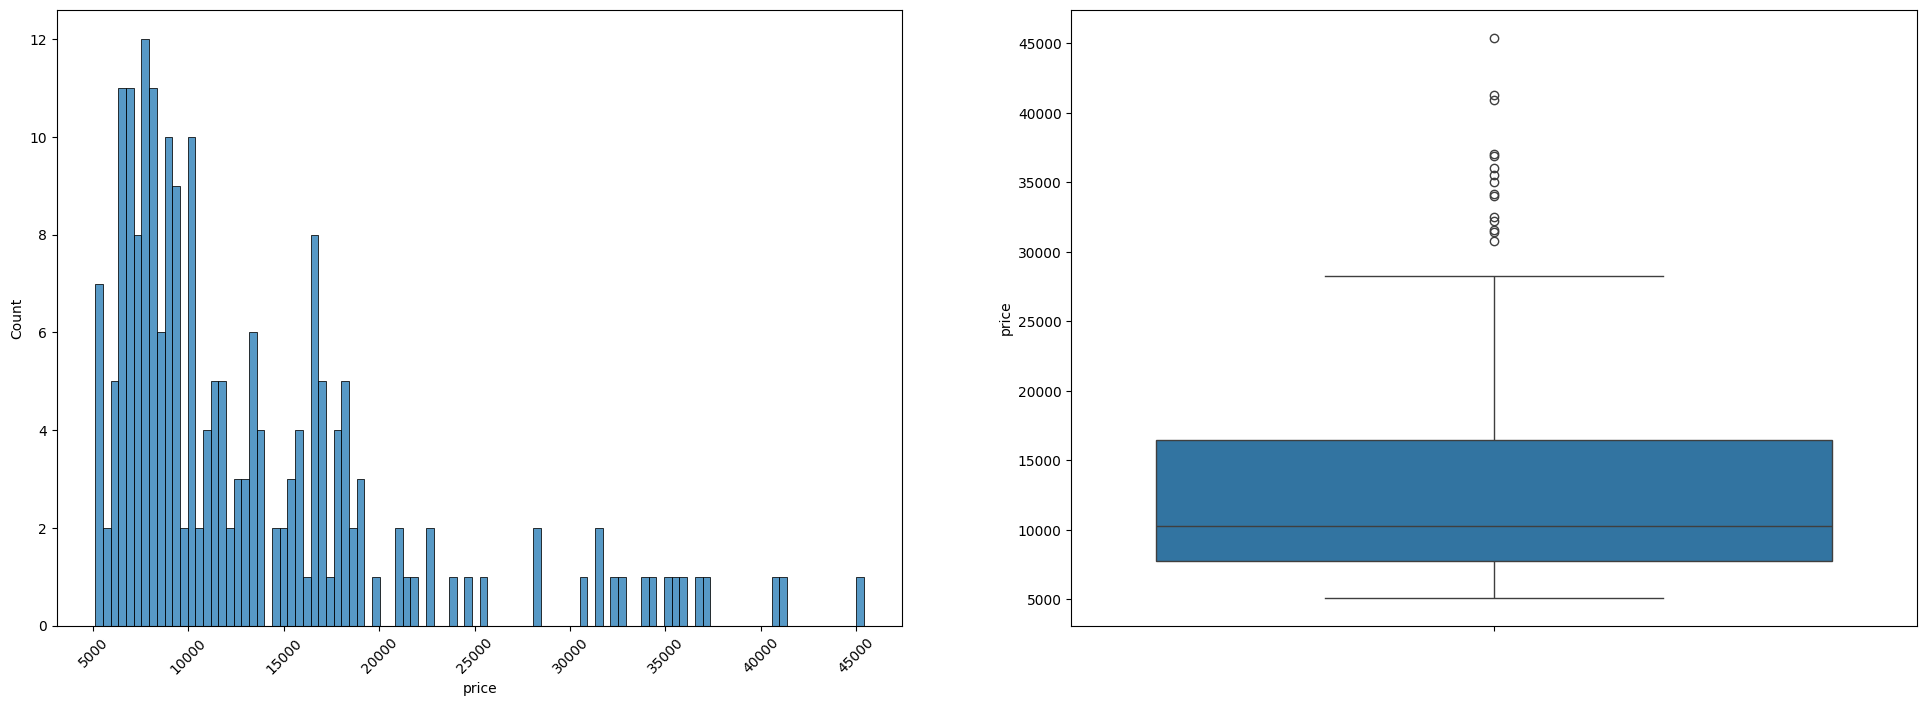

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.histplot(df[target_col], bins=100);

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.boxplot(df[target_col]);

# Предобработка данных

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("price", axis=1),
    df["price"],
    test_size=0.33,
    random_state=42
)

In [22]:
df.isna().sum()

symboling           0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
car_company         0
car_model_1         0
car_model_2         0
car_model_3         0
dtype: int64

В наших данных пропусков нет, поэтому этап их заполнения пропускаем (иначе нужно было бы заполнить их после того, как выборка поделена на обучающую и тестовую).

Поскольку части моделей необходимы нормализованные признаки (линейная регрессия, метод k-ближайших соседей), создадим несколько видов выборок: с нормализованными численными признаками и с ненормализованными численными признаками.

In [23]:
# Нормализация численных признаков

from sklearn.preprocessing import StandardScaler

X_train_num = X_train[numerical_cols]
X_test_num = X_test[numerical_cols]

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num.shape, X_test_num.shape, X_train_num_scaled.shape, X_test_num_scaled.shape, len(numerical_cols)

((137, 13), (68, 13), (137, 13), (68, 13), 13)

Категориальные переменные необходимо закодировать. Существует множество вариантов кодирования, среди которых наиболее распространенными являются:
1. [Порядковая кодировка](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Каждому новому значению признака присваивается новая метка. Обычно метки представляют собой числа от $0$ до $N –1$, где $N$ — количество уникальных значений признака. Поскольку принято обучать кодировщик на обучающей выборке, а тестовую выборку только изменять, может возникнуть ситуация, когда в тестовой выборке окажутся невстречающиеся ранее значения. Им присваивается новая переменная, например –1
2. [Кодирование One-hot ](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one+hot#sklearn.preprocessing.OneHotEncoder). Для каждого значения признака задается колонка, в которую проставляются $1$, если этот признак характерен для объекта, и $0$ в противном случае. Если поменять местами $1$ и $0$, то данный метод превратится кодирование в One-cold. Не подходит для признаков, которые имеют много уникальных значений

В данной задаче будет использоваться порядковый кодировщик.

In [24]:
# Кодирование категориальных признаков

from sklearn.preprocessing import OrdinalEncoder
import numpy as np

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_cat = np.empty(X_train[categorical_cols].shape, int)
X_test_cat = np.empty(X_test[categorical_cols].shape, int)

for j, col in enumerate(categorical_cols):
  X_train_cat[:, j] = encoder.fit_transform(X_train[col].values.reshape(-1, 1))[:, 0]
  X_test_cat[:, j] = encoder.transform(X_test[col].values.reshape(-1, 1))[:, 0]

X_train_cat.shape, X_test_cat.shape, len(categorical_cols)

((137, 14), (68, 14), 14)

In [25]:
X_train_new = np.hstack((X_train_num, X_train_cat))
X_test_new = np.hstack((X_test_num, X_test_cat))
X_train_new.shape, X_test_new.shape

((137, 27), (68, 27))

In [26]:
X_train_new_scaled = np.hstack((X_train_num_scaled, X_train_cat))
X_test_new_scaled = np.hstack((X_test_num_scaled, X_test_cat))
X_train_new_scaled.shape, X_test_new_scaled.shape

((137, 27), (68, 27))

# Линейная регрессия

Данная модель представляет собой линейную комбинацию векторов признаков и весов:
$$\hat{y} = a(x) = \sum_{i = 1}^{d}{w_ix_i+w_0},$$
где $\hat{y}$ — предсказания модели, $a$ — модель, $x = (x_1, ..., x_d)$ — вектор признаков, $w = (w_1, ..., w_d)$ — вектор весов, $w_0$ — смещение. Обучить линейную регрессию -- значит найти $w$ и $w_0$.  

Данная задача имеет аналитическое решение. Пусть $X$ — матрица признаков (размера $(n, k)$), $\omega = (\omega_1, ..., \omega_k)$ — вектор весов модели, $Y$ — матрица ответов (размерностью $(1, n)$). Поскольку наша модель должна наиболее точно аппроксимировать значения, будем минимизировать норму:
$$\min_w {||Y - X \omega|| ^ 2_2} \rightarrow 0$$
Возьмем производную и приравняем к 0:   
$$2X^T(Y - X \omega) = 0 \implies X \omega = Y$$
Так как матрица признаков не обязательно является квадратной, то домножим обе части справа на $X^T$:
$$X^TX \omega = X^TY,$$ обе части имеют размер $(n, n)$  
$$\implies \omega = (X^TX)^{-1} X^TY.$$

## Инициализация модели

Будем использовать готовую реализацию линейной регрессии из `sklearn`.

In [27]:
import numpy as np

np.random.seed(42) # зафиксируем состояние для воспроизводимости результатов

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
lr = LinearRegression()

## Обучение и тестирование модели

In [30]:
lr.fit(X_train_new_scaled, y_train)

LinearRegression()

Для оценки качества модели будем использовать среднеквадратичную ошибку и $R^2$-метрику.

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
pred_lr = lr.predict(X_test_new_scaled) # получение предсказаний
mse = mean_squared_error(y_test, pred_lr)
r2 = r2_score(y_test, pred_lr)
print("MSE = {}; R2 = {}".format(round(mse, 3), round(r2, 3)))

MSE = 13769282.285; R2 = 0.79


## Подбор гиперпараметров

Гиперпараметры играют важную роль в машинном обучении. Иногда бывает так, что гиперпараметры по умолчанию не позволяют модели обучаться, в то время как при определенной их комбинации качество модели значительно улучшается. Гиперпараметры линейной регрессии можно посмотреть [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).




In [33]:
from sklearn.model_selection import GridSearchCV

def gridsearch(X_train, y_train, model, params, scoring="neg_mean_squared_error", cv=5):
  """Перебор всевозможных гиперпараметров.

  :param X_train: объекты обучающей выборки
  :param y_train: значения целевой переменной обучающей выборки
  :param model: модель, для которой производится подбор гиперпараметров
  :param params: словарь с названиями гиперпараметрамов и всеми наборами значений
  :param scoring: функция, которая будет минимизироваться в ходе кросс-валидации
  :param cv: количество частей, на которые будет поделена выборка

  :return: наилучшие гиперпараметры
  """
  searcher = GridSearchCV(
      model,
      params,
      scoring=scoring,
      cv=cv
  )
  searcher.fit(X_train, y_train)
  best_params = searcher.best_params_

  print("Best hyperparameters:", best_params)
  return best_params

In [34]:
best_params_lr = gridsearch(
    X_train_new_scaled, y_train,
    LinearRegression(),
    {
        "fit_intercept": [True, False], # default = True
        "positive": [True, False], # default = False
    }
)

Best hyperparameters: {'fit_intercept': False, 'positive': False}


В данном случае наилучшими получились гиперпараметры по умолчанию. Ниже приведем функцию для обучения и тестирования модели. Эта функция понадобится нам для дальнейших экспериментов.

In [35]:
def model_train_test(X_train, y_train, X_test, y_test, model):
  """Обучение и тестирование модели на обучающей и тестовой выборке соответственно.

  :param X_train: объекты обучающей выборки
  :param y_train: значения целевой переменной обучающей выборки
  :param X_test: объекты тестовой выборки
  :param y_test: значения целевой переменной тестовой выборки
  :param model: модель, которая обучается и тестируется
  """
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  r2 = r2_score(y_test, pred)
  print("MSE = {}; R2 = {}".format(round(mse, 3), round(r2, 3)))

  return pred, mse, r2

In [36]:
pred_lr, mse_lr, r2_lr = model_train_test(
    X_train_new_scaled,
    y_train,
    X_test_new_scaled,
    y_test,
    LinearRegression(**best_params_lr)
)

MSE = 13902047.68; R2 = 0.788


## Модели с $L_1-$ и $L_2-$регуляризацией

При использовании какой-либо регуляризации в формулу добавляется еще одно слагаемое. Пусть $\hat{y}$ — предсказания модели, $a$ — модель, $x = (x_1,... , x_d)$ — вектор признаков, $w = (w_1, ..., w_d)$ — вектор весов. Тогда:
* $L_1-$регуляризация:  
$$\hat{y} = a(x) = \sum_{i = 1}^{d}{w_ix_i+ \lambda ||w||_1}$$

* $L_2-$регуляризация:
$$\hat{y} = a(x) = \sum_{i = 1}^{d}{w_ix_i+ \lambda ||w||_2^2}$$

Для этих моделей будем подбирать гиперпараметры и сравнивать модели с наилучшими гиперпараметрами с классической линейной регрессией.

In [37]:
from sklearn.linear_model import Ridge, Lasso

In [38]:
best_params_ridge = gridsearch(
    X_train_new_scaled, y_train,
    Ridge(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-3
    }
)

pred_ridge, mse_ridge, r2_ridge = model_train_test(
    X_train_new_scaled,
    y_train,
    X_test_new_scaled,
    y_test,
    Ridge(**best_params_ridge)
)

Best hyperparameters: {'alpha': 5.623413251903491, 'tol': 1e-05}
MSE = 12796307.539; R2 = 0.804


In [39]:
best_params_lasso = gridsearch(
    X_train_new_scaled, y_train,
    Lasso(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-4

    }
)

pred_lasso, mse_lasso, r2_lasso = model_train_test(
    X_train_new_scaled,
    y_train,
    X_test_new_scaled,
    y_test,
    Lasso(**best_params_lasso)
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e+06, tolerance: 7.362e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+07, tolerance: 7.115e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+07, tolerance: 6.412e

Best hyperparameters: {'alpha': 31.622776601683793, 'tol': 0.01}
MSE = 11820921.208; R2 = 0.819


Судя по MSE, Ridge-регрессия (регрессия с $L2-$регуляризацией) работает немного лучше классической линейной регрессии и чуть-чуть уступает Lasso-регрессии ($L1-$регуляризацией).

## Визуализация предсказаний

In [40]:
# Отсортируем значения целевой переменной и предсказания

order = np.argsort(y_test.values)
y_test_ordered = y_test.values[order]
pred_lr_ordered = pred_lr[order]
pred_ridge_ordered = pred_ridge[order]
pred_lasso_ordered = pred_lasso[order]

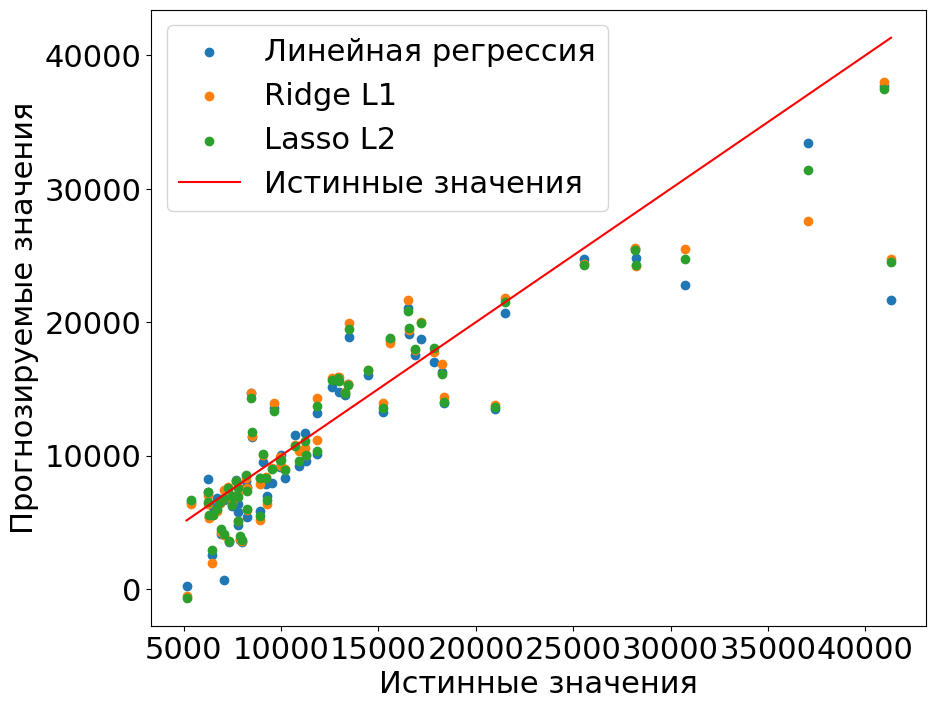

In [41]:
plt.rc('font', size=22) # далее во всех графиках будет использоваться такой же размер шрифта

plt.figure(figsize=(10, 8))

plt.scatter(y_test_ordered, pred_lr_ordered, label="Линейная регрессия")
plt.scatter(y_test_ordered, pred_ridge_ordered, label="Ridge L1")
plt.scatter(y_test_ordered, pred_lasso_ordered, label="Lasso L2")

plt.plot(y_test_ordered, y_test_ordered, label="Истинные значения", color="red")
plt.legend();

plt.xlabel("Истинные значения");
plt.ylabel("Прогнозируемые значения");

# Метод k-ближайших соседей

Предсказания модели выглядят следующим образом:

$$\hat{y} = a(x) = \frac{\sum_{k = 1}^K y_k}{K},$$ где $x$ — новый объект, для которого требуется построить прогноз, $K$ — число ближайших соседей, которых нужно рассматривать.

In [42]:
from sklearn.neighbors import KNeighborsRegressor

In [43]:
best_params_knn = gridsearch(
    X_train_new_scaled, y_train,
    KNeighborsRegressor(),
    {
        "n_neighbors": np.arange(1, 21), # default = 5
        "p": [1, 2], # default = 2
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"], # default = "auto"
    }
)

pred_knn, mse_knn, r2_knn = model_train_test(
    X_train_new_scaled,
    y_train,
    X_test_new_scaled,
    y_test,
    KNeighborsRegressor(**best_params_knn)
)

Best hyperparameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
MSE = 34883609.637; R2 = 0.467


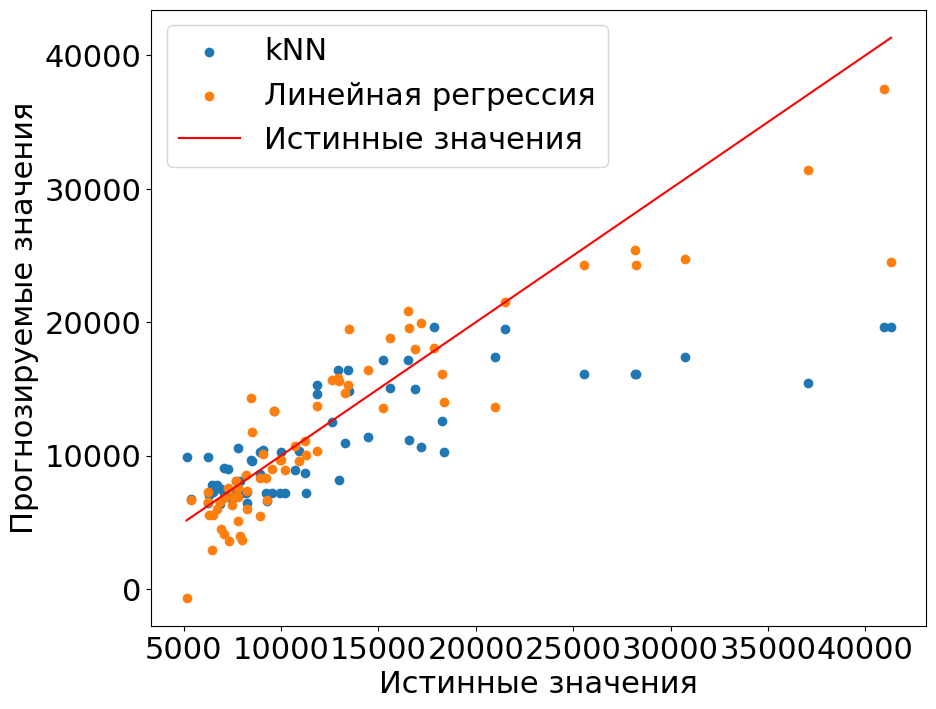

In [44]:
plt.figure(figsize=(10, 8))

plt.scatter(y_test_ordered, pred_knn[order], label="kNN")
plt.scatter(y_test_ordered, pred_lasso_ordered, label="Линейная регрессия")

plt.plot(y_test_ordered, y_test_ordered, label="Истинные значения", color="red")
plt.legend();

plt.xlabel("Истинные значения");
plt.ylabel("Прогнозируемые значения");

# Решающие деревья
Структура решающего дерева представляет собой бинарное дерево с ответами в листьях и условиями в узлах.

Существует несколько алгоритмов построения дерева решений:
* Алгоритм ID3, где выбор признака происходит на основании критерия Джини
* Алгоритм C4.5 (улучшенная версия ID3) и его модификации: IndCART, DB-CART. Выбор признака происходит на основании нормализованного прироста информации (Gain Ratio)
* Автоматический детектор взаимодействия хи-квадрат
* MARS: расширяет деревья решений для улучшения обработки цифровых данных  


На практике в результате работы этих алгоритмов часто получаются слишком глубокие деревья, т. е. данная модель переобучается, поэтому рекомендуется контролировать и тщательно подбирать данный гиперпараметр.

In [45]:
from sklearn.tree import DecisionTreeRegressor

In [46]:
best_params_dt = gridsearch(
    X_train_new, y_train,
    DecisionTreeRegressor(),
    {
        "max_depth": [None, 10] + [i for i in range(50, 351, 50)], # default = None
        "min_samples_leaf": [i for i in range(1, 41)], # default = 1
        "max_features": [None, "auto", "sqrt", "log2"] # default = None
    }
)

pred_dt, mse_dt, r2_dt = model_train_test(
    X_train_new,
    y_train,
    X_test_new,
    y_test,
    DecisionTreeRegressor(**best_params_dt)
)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

Best hyperparameters: {'max_depth': 350, 'max_features': 'auto', 'min_samples_leaf': 2}
MSE = 8414297.826; R2 = 0.871


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


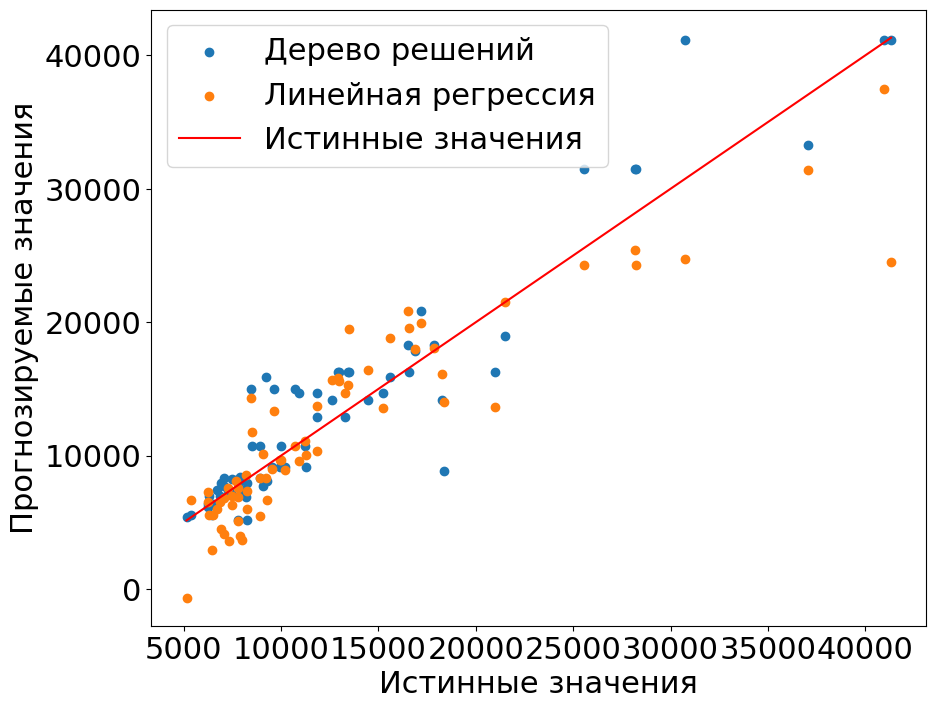

In [47]:
plt.figure(figsize=(10, 8))

plt.scatter(y_test_ordered, pred_dt[order], label="Дерево решений")
plt.scatter(y_test_ordered, pred_lasso_ordered, label="Линейная регрессия")

plt.plot(y_test_ordered, y_test_ordered, label="Истинные значения", color="red")
plt.legend();

plt.xlabel("Истинные значения");
plt.ylabel("Прогнозируемые значения");

# Ансамбли моделей
В данном примере рассмотрим случайный лес, в основе которого лежит бэггинг. Идея бэггинга состоит в том, что базовые модели обучаются независимо, что может достигаться двумя путями:

1. Одинаковые базовые модели обучаются на разных (независимых) подвыборках

2. Разные базовые модели обучаются на одной выборке. Случайный лес придерживается первого пути, в качестве базовых моделей в нем используются решающие деревья

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
best_params_rf = gridsearch(
    X_train_new, y_train,
    RandomForestRegressor(),
    {
        "max_depth": [None, 10] + [i for i in range(50, 351, 50)], # default = None
        "n_estimators": [i for i in range(50, 351, 50)], # default = 100
    }
)

pred_rf, mse_rf, r2_rf = model_train_test(
    X_train_new,
    y_train,
    X_test_new,
    y_test,
    RandomForestRegressor(**best_params_rf)
)

Best hyperparameters: {'max_depth': 150, 'n_estimators': 100}
MSE = 4206115.792; R2 = 0.936


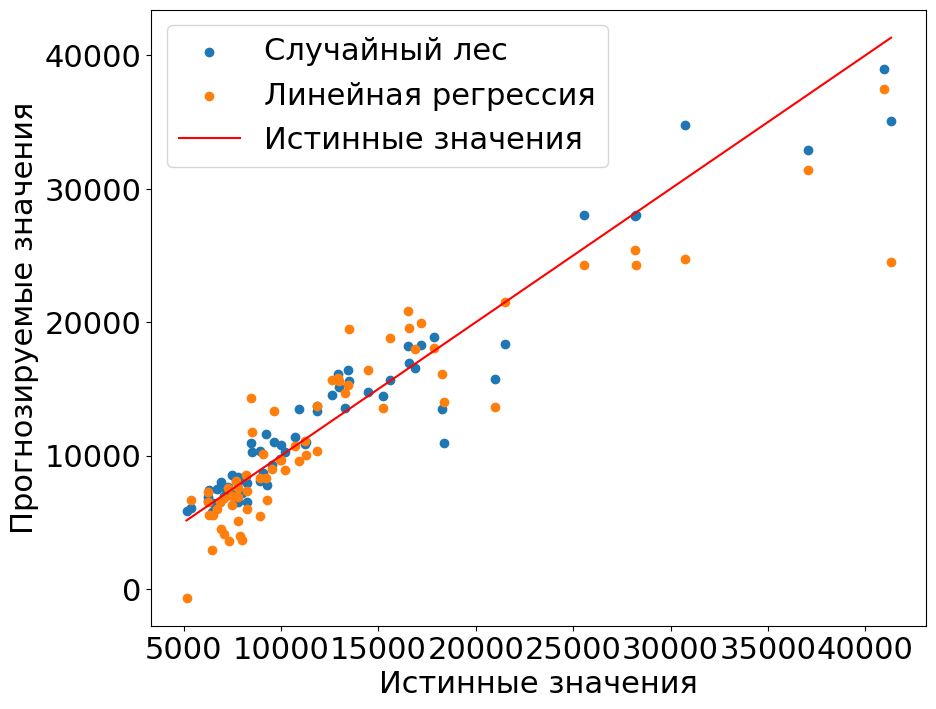

In [50]:
plt.figure(figsize=(10, 8))

plt.scatter(y_test_ordered, pred_rf[order], label="Случайный лес")
plt.scatter(y_test_ordered, pred_lasso_ordered, label="Линейная регрессия")

plt.plot(y_test_ordered, y_test_ordered, label="Истинные значения", color="red")
plt.legend();

plt.xlabel("Истинные значения");
plt.ylabel("Прогнозируемые значения");

# Подведение итогов

In [51]:
ans_df = pd.DataFrame()
ans_df["Model"] = ["Линейная регрессия", "Ridge L1", "Lasso L2", "kNN", "Дерево решений", "Случайный лес"]
ans_df["MSE"] = [mse_lr, mse_ridge, mse_lasso, mse_knn, mse_dt, mse_rf]
ans_df["R2"] = [r2_lr, r2_ridge, r2_lasso, r2_knn, r2_dt, r2_rf]

In [52]:
ans_df.sort_values(by=["MSE"], ascending=True).sort_values(by=["R2"], ascending=False)

,Model,MSE,R2
5,Случайный лес,4.206116e+06,0.935721
4,Дерево решений,8.414298e+06,0.871410
2,Lasso L2,1.182092e+07,0.819349
1,Ridge L1,1.279631e+07,0.804443
0,Линейная регрессия,1.390205e+07,0.787545
3,kNN,3.488361e+07,0.466899


Таким образом, судя по $R^2$, почти все модели демонстрируют неплохое качество, но в данном случае наиболее хорошо себя проявил случайный лес.